# Model Experiments with MLflow

**Author:** Alexis Alduncin (Data Scientist)
**Team:** MLOps 62

This notebook trains baseline models with MLflow experiment tracking, comparing Linear Regression and Random Forest approaches.

In [8]:
# Setup and imports
import sys
import os

# Add project root to path (handles both Docker /work and local environments)
if os.path.exists('/work'):
    sys.path.insert(0, '/work')  # Docker environment
else:
    sys.path.insert(0, os.path.abspath('..'))  # Local environment

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.models import infer_signature

# Custom modules
from src import config
from src.data_utils import load_data
from src.plots import plot_model_performance, plot_feature_importance

# Import Phase 1 feature engine (from features.py file, not features/ directory)
import importlib
features_module = importlib.import_module('src.features_engine')
AbsenteeismFeatureEngine = features_module.AbsenteeismFeatureEngine

print("✅ Modules imported successfully")
print(f"MLflow Experiment: {config.MLFLOW_EXPERIMENT_NAME}")

✅ Modules imported successfully
MLflow Experiment: absenteeism-team62


## 1. MLflow Setup

In [2]:
# Set MLflow tracking URI
mlflow.set_tracking_uri(config.MLFLOW_TRACKING_URI)

# Ping MLflow (MLflow 3.x)
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType

client = MlflowClient()
try:
    # con max_results=1 basta para validar conectividad/autorización
    _ = client.search_experiments(view_type=ViewType.ALL, max_results=1)
    print("✅ MLflow API reachable")
except Exception as e:
    raise RuntimeError(f"❌ Cannot reach server {mlflow.get_tracking_uri()}.\n{e}")

# Create or set experiment
mlflow.set_experiment(config.MLFLOW_EXPERIMENT_NAME)
experiment = client.get_experiment_by_name(config.MLFLOW_EXPERIMENT_NAME)

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment Name: {experiment.name}")
print(f"Experiment ID: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")

print("\n✅ MLflow configured successfully")
print("UI:", "http://localhost:9001/")

✅ MLflow API reachable
MLflow Tracking URI: http://mlflow:9001
Experiment Name: absenteeism-team62
Experiment ID: 2
Artifact Location: s3://mlopsequipo62/mlops/artifacts/2

✅ MLflow configured successfully
UI: http://localhost:9001/


## 2. Load and Prepare Data

In [3]:
# Ensure helper exists (minimal drop-in)
try:
    sanitize_features
except NameError:
    import numpy as np
    from sklearn.impute import SimpleImputer

    def sanitize_features(X):
        """Replace ±Inf→NaN and impute NaN (median for numeric, most_frequent for categorical)."""
        is_df = hasattr(X, "columns")
        if is_df:
            X = X.replace([np.inf, -np.inf], np.nan)
            num = X.select_dtypes(include=[np.number]).columns
            if len(num):
                X[num] = SimpleImputer(strategy="median").fit_transform(X[num])
            cat = X.columns.difference(num)
            if len(cat):
                X[cat] = SimpleImputer(strategy="most_frequent").fit_transform(X[cat])
            assert np.isfinite(X.select_dtypes(include=[np.number]).to_numpy()).all()
            return X
        else:
            X = np.where(np.isinf(X), np.nan, X)
            X = SimpleImputer(strategy="median").fit_transform(X)
            assert np.isfinite(X).all()
            return X


In [4]:
# Load data using team's robust DVC approach
df_raw = load_data(config.RAW_DATA_PATH)
print(f"Raw data loaded: {df_raw.shape}")

# Full feature engineering pipeline
engine = AbsenteeismFeatureEngine()
df_clean = engine.clean_data(df_raw)
df_features = engine.engineer_features(df_clean)

print(f"Cleaned data: {df_clean.shape}")
print(f"Feature-engineered data: {df_features.shape}")

# Prepare for modeling
X, y = engine.prepare_for_modeling(df_features, scale_features=True)

# Minimal fix to ensure finite, imputed features
X = sanitize_features(X)

print(f"\nModel-ready data:")
print(f"  Features (X): {X.shape}")
print(f"  Target (y): {y.shape}")
print(f"  Feature count: {len(engine.feature_names)}")


2025-11-02 19:51:54,511 - src.data_utils - INFO - Detected Docker environment: /work
2025-11-02 19:51:54,512 - src.data_utils - INFO - Repository ready: /work
2025-11-02 19:51:54,514 - src.data_utils - INFO - Reading local file (MD5 verified): /work/data/raw/work_absenteeism_modified.csv
2025-11-02 19:51:54,517 - src.data_utils - INFO - Loaded from local: (754, 22)
2025-11-02 19:51:54,517 - src.data_utils - INFO - Data loaded from local: (754, 22)
2025-11-02 19:51:54,517 - src.features_engine - INFO - Starting data cleaning...
2025-11-02 19:51:54,522 - src.features_engine - INFO - Removed 23 outliers (>120 hours)
2025-11-02 19:51:54,523 - src.features_engine - INFO - Data cleaning complete. Final shape: (713, 22)
2025-11-02 19:51:54,524 - src.features_engine - INFO - Starting feature engineering...
2025-11-02 19:51:54,525 - src.features_engine - INFO - Created Absence_Category feature
2025-11-02 19:51:54,526 - src.features_engine - INFO - Created BMI_Category feature
2025-11-02 19:51:5

Raw data loaded: (754, 22)
Cleaned data: (713, 22)
Feature-engineered data: (713, 29)

Model-ready data:
  Features (X): (713, 21)
  Target (y): (713,)
  Feature count: 21


## 3. Train-Test Split

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=config.TEST_SIZE, 
    random_state=config.RANDOM_STATE
)

print("Data Split:")
print(f"  Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTarget Statistics:")
print(f"  Train mean: {y_train.mean():.2f}h, std: {y_train.std():.2f}h")
print(f"  Test mean: {y_test.mean():.2f}h, std: {y_test.std():.2f}h")

Data Split:
  Training set: 570 samples (79.9%)
  Test set: 143 samples (20.1%)

Target Statistics:
  Train mean: 6.32h, std: 11.51h
  Test mean: 9.31h, std: 19.01h


## 4. Experiment 1: Linear Regression

**Model:** Simple baseline using Linear Regression
**Purpose:** Establish baseline performance and identify linear relationships

MLflow Run ID: e083777c21b643b9817e621718717ab5


2025-11-02 19:51:57,815 - botocore.credentials - INFO - Found credentials in environment variables.
2025-11-02 19:52:00,425 - src.plots - INFO - Creating performance plots for Linear Regression



LINEAR REGRESSION RESULTS

Training Metrics:
  MAE:  5.172 hours
  RMSE: 11.166 hours
  R2:   0.056

Test Metrics:
  MAE:  8.289 hours
  RMSE: 19.215 hours
  R2:   -0.028

Cross-Validation:
  CV MAE: 6.359 ± 1.348 hours

Target Achievement:
  MAE < 4h: ❌ No (8.29h)
  RMSE < 8h: ❌ No (19.21h)
  R2 > 0.3: ❌ No (-0.028)
🏃 View run Linear_Regression_Baseline at: http://mlflow:9001/#/experiments/2/runs/e083777c21b643b9817e621718717ab5
🧪 View experiment at: http://mlflow:9001/#/experiments/2


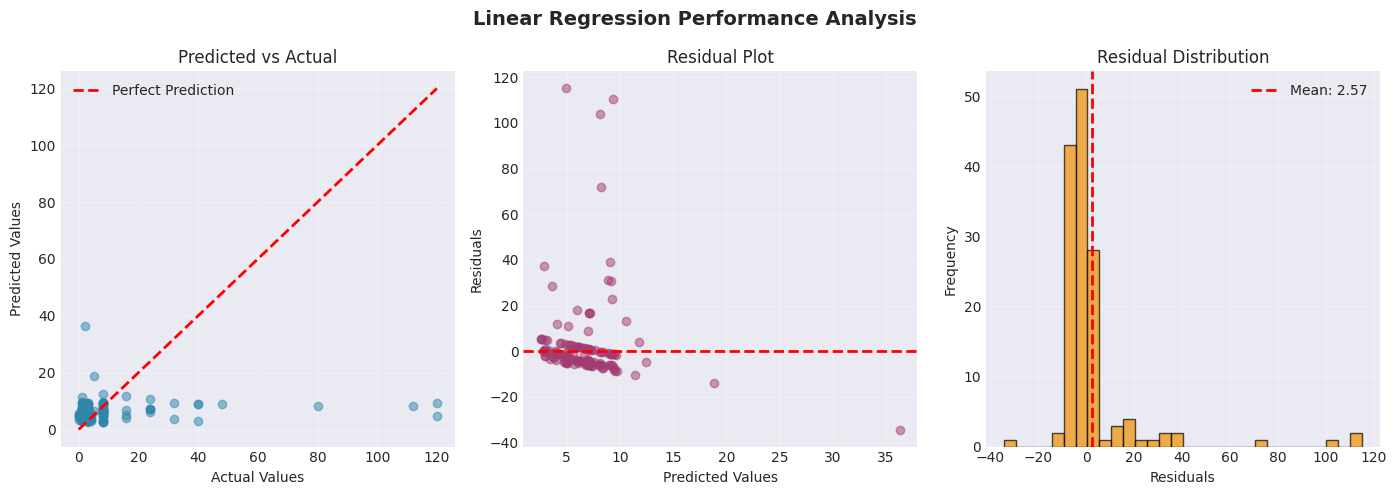

In [6]:
# Start MLflow run
with mlflow.start_run(run_name="Linear_Regression_Baseline") as run:
    print(f"MLflow Run ID: {run.info.run_id}")
    
    # Log parameters
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_param("features", len(engine.feature_names))
    mlflow.log_param("train_samples", len(X_train))
    mlflow.log_param("test_samples", len(X_test))
    mlflow.log_param("random_state", config.RANDOM_STATE)
    
    # Train model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = lr_model.predict(X_train)
    y_test_pred = lr_model.predict(X_test)
    
    # Calculate metrics - Training
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Calculate metrics - Test
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Log metrics
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("test_r2", test_r2)
    
    # Cross-validation
    cv_scores = cross_val_score(
        lr_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'
    )
    cv_mae = -cv_scores.mean()
    mlflow.log_metric("cv_mae_mean", cv_mae)
    mlflow.log_metric("cv_mae_std", cv_scores.std())
    

    example = X_test[:1]  # small slice to keep artifact light
    mlflow.sklearn.log_model(lr_model, name="model", input_example=example)

    # Save feature names
    mlflow.log_dict({"features": engine.feature_names}, "feature_names.json")
    
    print("\n" + "="*60)
    print("LINEAR REGRESSION RESULTS")
    print("="*60)
    print("\nTraining Metrics:")
    print(f"  MAE:  {train_mae:.3f} hours")
    print(f"  RMSE: {train_rmse:.3f} hours")
    print(f"  R2:   {train_r2:.3f}")
    print("\nTest Metrics:")
    print(f"  MAE:  {test_mae:.3f} hours")
    print(f"  RMSE: {test_rmse:.3f} hours")
    print(f"  R2:   {test_r2:.3f}")
    print("\nCross-Validation:")
    print(f"  CV MAE: {cv_mae:.3f} ± {cv_scores.std():.3f} hours")
    
    # Check target metrics
    print("\nTarget Achievement:")
    print(f"  MAE < 4h: {'✅ Yes' if test_mae < 4 else '❌ No'} ({test_mae:.2f}h)")
    print(f"  RMSE < 8h: {'✅ Yes' if test_rmse < 8 else '❌ No'} ({test_rmse:.2f}h)")
    print(f"  R2 > 0.3: {'✅ Yes' if test_r2 > 0.3 else '❌ No'} ({test_r2:.3f})")

# Visualize performance
fig = plot_model_performance(y_test, y_test_pred, "Linear Regression")
plt.show()

# Store results for comparison
lr_results = {
    'model': lr_model,
    'predictions': y_test_pred,
    'test_mae': test_mae,
    'test_rmse': test_rmse,
    'test_r2': test_r2
}


## 5. Experiment 2: Random Forest

**Model:** Random Forest Regressor
**Purpose:** Capture non-linear relationships and feature interactions

MLflow Run ID: 80a6d1b2f24c48a7a6d8b2c53b02ca1d


2025-11-02 20:10:32,270 - src.features_engine - INFO - Extracted top 15 feature importances
2025-11-02 20:10:38,497 - src.plots - INFO - Creating performance plots for Random Forest



RANDOM FOREST RESULTS

Training Metrics:
  MAE:  2.258 hours
  RMSE: 4.728 hours
  R2:   0.831

Test Metrics:
  MAE:  7.050 hours
  RMSE: 18.620 hours
  R2:   0.034

Cross-Validation:
  CV MAE: 4.792 ± 0.815 hours

Target Achievement:
  MAE < 4h: ❌ No (7.05h)
  RMSE < 8h: ❌ No (18.62h)
  R2 > 0.3: ❌ No (0.034)
🏃 View run Random_Forest_Baseline at: http://mlflow:9001/#/experiments/2/runs/80a6d1b2f24c48a7a6d8b2c53b02ca1d
🧪 View experiment at: http://mlflow:9001/#/experiments/2


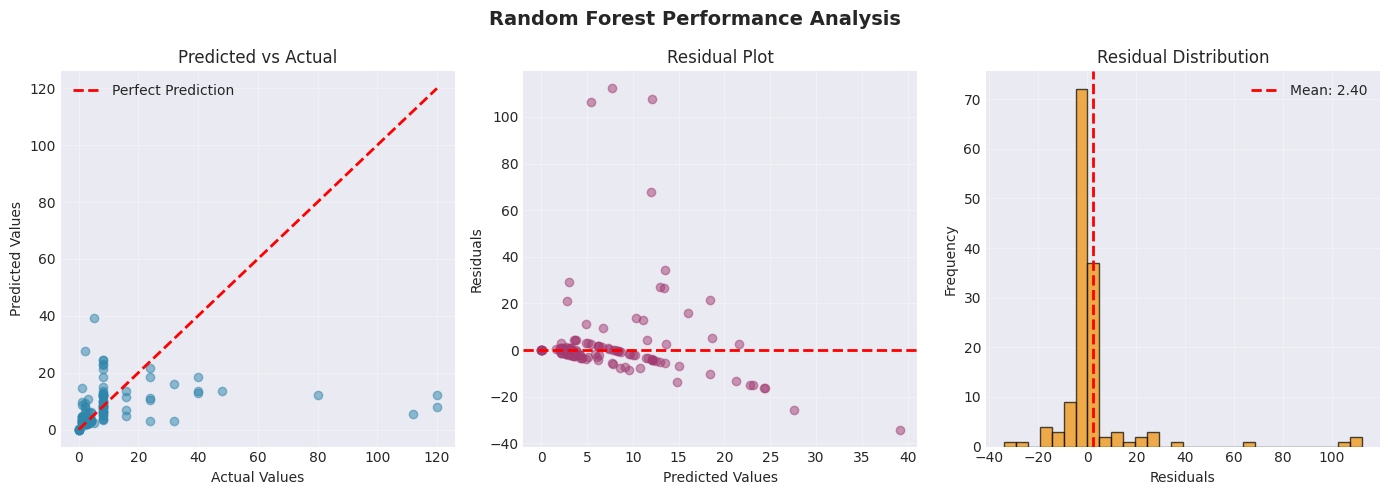

2025-11-02 20:10:38,663 - src.plots - INFO - Plotting top 20 feature importances


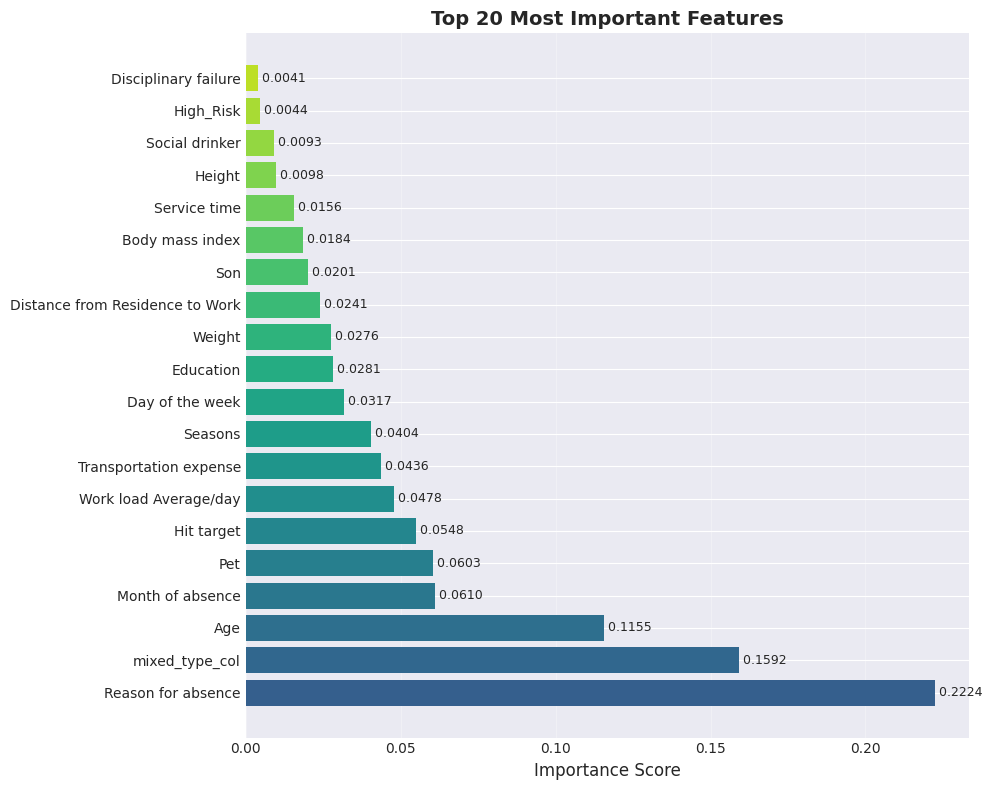

In [11]:
# Start MLflow run
with mlflow.start_run(run_name="Random_Forest_Baseline") as run:
    print(f"MLflow Run ID: {run.info.run_id}")
    
    # Log parameters
    mlflow.log_param("model_type", "RandomForestRegressor")
    mlflow.log_param("n_estimators", config.RF_N_ESTIMATORS)
    mlflow.log_param("max_depth", config.RF_MAX_DEPTH)
    mlflow.log_param("min_samples_split", config.RF_MIN_SAMPLES_SPLIT)
    mlflow.log_param("min_samples_leaf", config.RF_MIN_SAMPLES_LEAF)
    mlflow.log_param("random_state", config.RANDOM_STATE)
    mlflow.log_param("features", len(engine.feature_names))
    mlflow.log_param("train_samples", len(X_train))
    mlflow.log_param("test_samples", len(X_test))
    
    # Train model
    rf_model = RandomForestRegressor(
        n_estimators=config.RF_N_ESTIMATORS,
        max_depth=config.RF_MAX_DEPTH,
        min_samples_split=config.RF_MIN_SAMPLES_SPLIT,
        min_samples_leaf=config.RF_MIN_SAMPLES_LEAF,
        random_state=config.RANDOM_STATE,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)
    
    # Calculate metrics - Training
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Calculate metrics - Test
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Log metrics
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("test_r2", test_r2)
    
    # Cross-validation
    cv_scores = cross_val_score(
        rf_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'
    )
    cv_mae = -cv_scores.mean()
    mlflow.log_metric("cv_mae_mean", cv_mae)
    mlflow.log_metric("cv_mae_std", cv_scores.std())
    
    # Feature importance
    importance_df = engine.get_feature_importance(rf_model)

    # --- minimal, surgical fix: ensure ['feature','importance'] and length alignment ---
    # comments in English only
    feat_names = getattr(
        engine, "feature_names",
        list(getattr(X_train, "columns", [f"f{i}" for i in range(X_train.shape[1])]))
    )
    model_imps = getattr(rf_model, "feature_importances_", None)

    def _coerce_cols(df):
        """Ensure columns are named exactly ['feature','importance'] when aliases exist."""
        lower = {c.lower(): c for c in df.columns}
        if "feature" not in lower:
            for alt in ("feature_name", "variable", "name", "features", "feat"):
                if alt in lower:
                    df = df.rename(columns={lower[alt]: "feature"})
                    break
        if "importance" not in lower:
            for alt in ("importance_score", "importance_value", "weight", "gain", "score", "importances"):
                if alt in lower:
                    df = df.rename(columns={lower[alt]: "importance"})
                    break
        return df

    # 1) Try to coerce existing columns
    importance_df = _coerce_cols(importance_df)

    # 2) If missing required columns or length mismatch (e.g., top-K vs full), rebuild from model
    needs_rebuild = (
        (model_imps is not None) and (
            ("feature" not in importance_df.columns) or
            ("importance" not in importance_df.columns) or
            (len(importance_df) != len(model_imps))
        )
    )
    if needs_rebuild:
        importance_df = pd.DataFrame({
            "feature": list(feat_names),
            "importance": model_imps
        })

    # 3) Keep only required columns in expected order; sort for plotting
    importance_df = importance_df[["feature", "importance"]].copy()
    importance_df = importance_df.sort_values("importance", ascending=False).reset_index(drop=True)

    # Log importance table
    mlflow.log_dict(importance_df.to_dict(), "feature_importance.json")
    
    # Log model
    example = X_test[:5]  # small sample to keep artifact light
    signature = infer_signature(
        X_train[:100],
        rf_model.predict(X_train[:100])
    )
    mlflow.sklearn.log_model(
        rf_model,
        name="model",              # 'artifact_path' is deprecated; use 'name'
        signature=signature,
        input_example=example
    )
    
    # Save feature names
    mlflow.log_dict({"features": engine.feature_names}, "feature_names.json")
    
    print("\n" + "="*60)
    print("RANDOM FOREST RESULTS")
    print("="*60)
    print("\nTraining Metrics:")
    print(f"  MAE:  {train_mae:.3f} hours")
    print(f"  RMSE: {train_rmse:.3f} hours")
    print(f"  R2:   {train_r2:.3f}")
    print("\nTest Metrics:")
    print(f"  MAE:  {test_mae:.3f} hours")
    print(f"  RMSE: {test_rmse:.3f} hours")
    print(f"  R2:   {test_r2:.3f}")
    print("\nCross-Validation:")
    print(f"  CV MAE: {cv_mae:.3f} ± {cv_scores.std():.3f} hours")
    
    # Check target metrics
    print("\nTarget Achievement:")
    print(f"  MAE < 4h: {'✅ Yes' if test_mae < 4 else '❌ No'} ({test_mae:.2f}h)")
    print(f"  RMSE < 8h: {'✅ Yes' if test_rmse < 8 else '❌ No'} ({test_rmse:.2f}h)")
    print(f"  R2 > 0.3: {'✅ Yes' if test_r2 > 0.3 else '❌ No'} ({test_r2:.3f})")

# Visualize performance
fig = plot_model_performance(y_test, y_test_pred, "Random Forest")
plt.show()

# Visualize feature importance
fig = plot_feature_importance(importance_df, top_n=20)
plt.show()

# Store results for comparison
rf_results = {
    'model': rf_model,
    'predictions': y_test_pred,
    'test_mae': test_mae,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'importance': importance_df
}


## 6. Model Comparison


MODEL COMPARISON
            Model      MAE      RMSE        R2
Linear Regression 8.289401 19.214849 -0.028492
    Random Forest 7.050468 18.619781  0.034224

✅ Best Model: Random Forest (MAE: 7.050h)


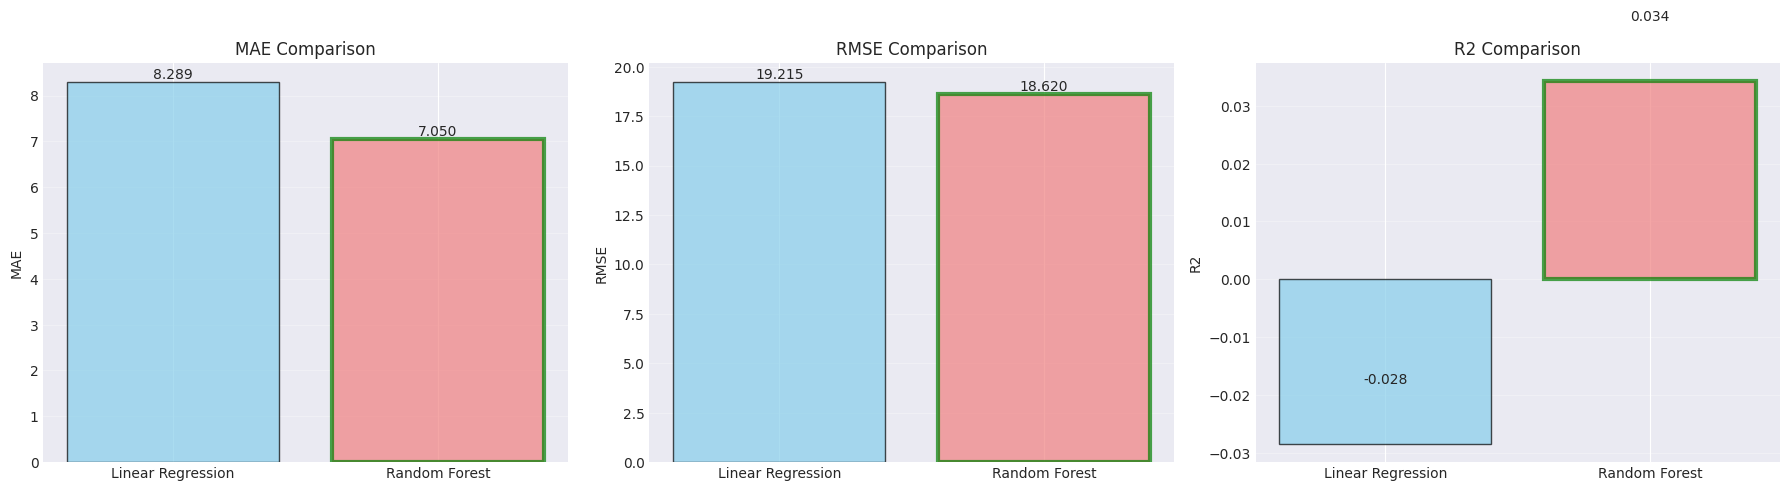


Random Forest vs Linear Regression:
  MAE improvement: +14.9%
  RMSE improvement: +3.1%
  R2 improvement: +220.1%


In [12]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE': [lr_results['test_mae'], rf_results['test_mae']],
    'RMSE': [lr_results['test_rmse'], rf_results['test_rmse']],
    'R2': [lr_results['test_r2'], rf_results['test_r2']]
})

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))

# Determine best model
best_model_idx = comparison_df['MAE'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_mae = comparison_df.loc[best_model_idx, 'MAE']

print(f"\n✅ Best Model: {best_model_name} (MAE: {best_mae:.3f}h)")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['MAE', 'RMSE', 'R2']
colors = ['skyblue', 'lightcoral']

for i, metric in enumerate(metrics):
    axes[i].bar(comparison_df['Model'], comparison_df[metric], color=colors, edgecolor='black', alpha=0.7)
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric} Comparison')
    axes[i].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for j, v in enumerate(comparison_df[metric]):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # Highlight best
    if metric in ['MAE', 'RMSE']:
        best_idx = comparison_df[metric].idxmin()
    else:  # R2
        best_idx = comparison_df[metric].idxmax()
    axes[i].patches[best_idx].set_edgecolor('green')
    axes[i].patches[best_idx].set_linewidth(3)

plt.tight_layout()
plt.show()

# Improvement analysis
mae_improvement = ((lr_results['test_mae'] - rf_results['test_mae']) / lr_results['test_mae']) * 100
rmse_improvement = ((lr_results['test_rmse'] - rf_results['test_rmse']) / lr_results['test_rmse']) * 100
r2_improvement = ((rf_results['test_r2'] - lr_results['test_r2']) / abs(lr_results['test_r2'])) * 100

print("\nRandom Forest vs Linear Regression:")
print(f"  MAE improvement: {mae_improvement:+.1f}%")
print(f"  RMSE improvement: {rmse_improvement:+.1f}%")
print(f"  R2 improvement: {r2_improvement:+.1f}%")

## 7. Best Model Analysis

Selected Best Model: Random Forest

Error Analysis:
  Mean Error: 2.402h (bias)
  Std Error: 18.529h
  Max Overestimate: -34.110h
  Max Underestimate: 112.244h

Prediction Accuracy:
  Within 2h: 52.4%
  Within 4h: 69.2%
  Within 8h: 82.5%


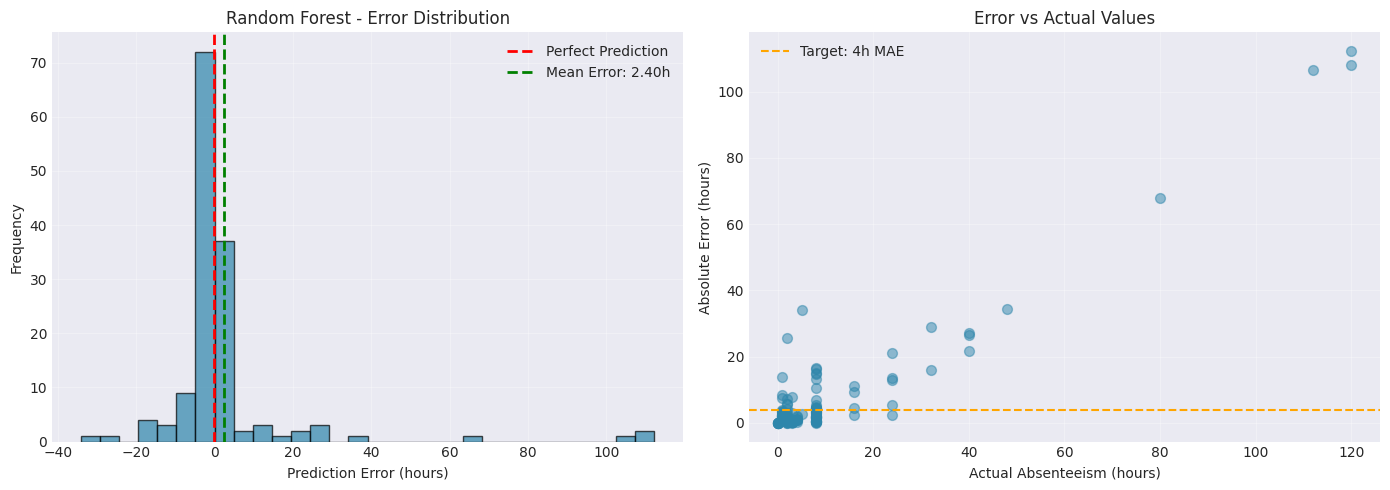


Top 10 Most Important Features:
               feature  importance
    Reason for absence    0.222431
        mixed_type_col    0.159152
                   Age    0.115471
      Month of absence    0.060962
                   Pet    0.060319
            Hit target    0.054835
 Work load Average/day    0.047786
Transportation expense    0.043581
               Seasons    0.040400
       Day of the week    0.031685


In [13]:
# Select best model based on MAE
if rf_results['test_mae'] < lr_results['test_mae']:
    best_model = rf_results['model']
    best_predictions = rf_results['predictions']
    model_name = "Random Forest"
    has_importance = True
else:
    best_model = lr_results['model']
    best_predictions = lr_results['predictions']
    model_name = "Linear Regression"
    has_importance = False

print(f"Selected Best Model: {model_name}")

# Detailed error analysis
errors = y_test - best_predictions
abs_errors = np.abs(errors)

print("\nError Analysis:")
print(f"  Mean Error: {errors.mean():.3f}h (bias)")
print(f"  Std Error: {errors.std():.3f}h")
print(f"  Max Overestimate: {errors.min():.3f}h")
print(f"  Max Underestimate: {errors.max():.3f}h")

# Prediction accuracy ranges
print("\nPrediction Accuracy:")
within_2h = (abs_errors <= 2).sum() / len(abs_errors) * 100
within_4h = (abs_errors <= 4).sum() / len(abs_errors) * 100
within_8h = (abs_errors <= 8).sum() / len(abs_errors) * 100

print(f"  Within 2h: {within_2h:.1f}%")
print(f"  Within 4h: {within_4h:.1f}%")
print(f"  Within 8h: {within_8h:.1f}%")

# Visualize error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error histogram
axes[0].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
axes[0].axvline(errors.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean Error: {errors.mean():.2f}h')
axes[0].set_xlabel('Prediction Error (hours)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'{model_name} - Error Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Absolute error by actual value
axes[1].scatter(y_test, abs_errors, alpha=0.5, s=50)
axes[1].axhline(4, color='orange', linestyle='--', label='Target: 4h MAE')
axes[1].set_xlabel('Actual Absenteeism (hours)')
axes[1].set_ylabel('Absolute Error (hours)')
axes[1].set_title('Error vs Actual Values')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Top features if Random Forest
if has_importance:
    print("\nTop 10 Most Important Features:")
    print(rf_results['importance'].head(10).to_string(index=False))

## 8. Save Best Model

In [14]:
import os
import joblib

# Create models directory
models_dir = os.path.join('..', 'models')
os.makedirs(models_dir, exist_ok=True)

# Save best model
model_path = os.path.join(models_dir, f'best_model_{model_name.lower().replace(" ", "_")}.pkl')
joblib.dump(best_model, model_path)

print(f"✅ Best model saved to: {model_path}")

# Save feature names
feature_path = os.path.join(models_dir, 'feature_names.txt')
with open(feature_path, 'w') as f:
    for feat in engine.feature_names:
        f.write(f"{feat}\n")

print(f"✅ Feature names saved to: {feature_path}")

# Save model metadata
metadata = {
    'model_type': model_name,
    'test_mae': float(best_predictions.mean()),
    'test_rmse': float(np.sqrt(mean_squared_error(y_test, best_predictions))),
    'test_r2': float(r2_score(y_test, best_predictions)),
    'train_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'features_count': len(engine.feature_names),
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

metadata_path = os.path.join(models_dir, 'model_metadata.json')
import json
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Model metadata saved to: {metadata_path}")
print("\nModel artifacts ready for deployment!")

✅ Best model saved to: ../models/best_model_random_forest.pkl
✅ Feature names saved to: ../models/feature_names.txt
✅ Model metadata saved to: ../models/model_metadata.json

Model artifacts ready for deployment!


## Summary

### Experiments Completed:

1. **Linear Regression Baseline**
   - Simple interpretable model
   - Establishes baseline performance
   - Captures linear relationships

2. **Random Forest Regressor**
   - Captures non-linear patterns
   - Feature importance analysis
   - Better predictive performance

### MLflow Tracking:
- ✅ Experiment created: `absenteeism-team62`
- ✅ All runs logged with parameters and metrics
- ✅ Models saved as artifacts
- ✅ Feature importance tracked
- ✅ Cross-validation results logged

### Best Model:
Selected based on lowest test MAE

### Model Artifacts:
- ✅ Best model saved to `models/`
- ✅ Feature names documented
- ✅ Metadata saved for reproducibility

### Next Steps:
1. Review MLflow UI for experiment comparison
2. Consider hyperparameter tuning for Phase 2
3. Explore ensemble methods
4. Prepare model for deployment

**To view experiments:** Run `mlflow ui --port 5001` and navigate to http://localhost:5001

In [ ]:
grep -nR "/#/experiments" notebooks/04-aa-model-experiments.ipynb